# PilotNet SDNN Benchmarking Example

This tutorial demonstrates how to use __lava__ to perform __energy__, __execution__, __memory__ and __activity__ on a PilotNet SDNN network running on Loihi 2. _Note: This tutorial only runs on Lohi 2 backend._

![PilotNet Inference](images/pilotnet_sdnn_profiling.PNG)

Lava's Lohi 2 profiling moudule `lava.utils.loihi2_profiler` (only avalilable with Lohi 2 compiler of lava) provides tools to measure the prformance of a network running on Loihi 2. There are four profiling tools available.

* __Power Profiler__ : `loihi2_profiler.Loihi2Power`
  It provides power measurement tools for the Loihi 2 system. Power measurement is a slow process, therefore, it is recommended to run the network for long enough time to measure power accurately. It also measures static power when the workload is done running.
* __Execution Time Profiler__ : `loihi2_profiler.Loihi2ExecutionTime`
  It provides execution time measurements of the workload running on Loihi 2 system at a granularity of each individual time step.
* __Activity Profiler__ : `loihi2_profiler.Loihi2Activity`
  It provides the counts of neurocore activities like input spikes, output spikes, neuron updates, synops, etc. at the granularity of each Loihi 2 neurocore.
* __Memory Profiler__ : `loihi2_profiler.Loihi2Memory`
  It provides the degree of neurocore SRAM utilization at the granularity of each Loihi 2 neurocore.

Refer to [run.ipynb](https://github.com/lava-nc/lava-dl/blob/main/tutorials/lava/lib/dl/netx/pilotnet_sdnn/run.ipynb) for detailed walkthrough of how to inference the network on both CPU and Loihi 2.

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc import io

from lava.lib.dl import netx
from dataset import PilotNetDataset
from utils import PilotNetEncoder, PilotNetNxEncoderModel, get_input_transform

# Import modules for Loihi2 execution

Check if Loihi2 compiker is available and import related modules.

In [2]:
from lava.utils.system import Loihi2
Loihi2.preferred_partition = 'oheogulch'
loihi2_is_available = Loihi2.is_loihi2_available

import os
os.environ['BOARD'] = 'ncl-og-04'

if loihi2_is_available:
    from lava.utils import loihi2_profiler
    print(f'Running on {Loihi2.partition}')
    compression = io.encoder.Compression.DELTA_SPARSE_8
else:
    RuntimeError("Loihi2 compiler is not available in this system. "
                 "This tutorial cannot proceed further.")

Running on oheogulch


## Create network block

PilotNet LIF is described by the hdf5 file inference `network.net`.

In [3]:
num_steps = 2000 # Run for a very long time to get good power measurement
net = netx.hdf5.Network(net_config='network.net', skip_layers=1)
print(net)


|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Conv      |   99|   32|   24| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   49|   15|   36| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   24|    7|   48| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   22|    4|   64| 3, 3| 1, 2| 0, 1| 1, 1|    1|False|
|Conv      |   20|    2|   64| 3, 3| 1, 1| 0, 0| 1, 1|    1|False|
|Dense     |    1|    1|  100|     |     |     |     |     |False|
|Dense     |    1|    1|   50|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|
|Dense     |    1|    1|    1|     |     |     |     |     |False|


## Create Dataset, Dataloader, Input encoder and connect them

In [4]:
transform = get_input_transform(net.net_config)
full_set = PilotNetDataset(
    path='../data',
    size=net.inp.shape[:2],
    transform=transform,  # input transform
    visualize=True,  # visualize ensures the images are returned in sequence
    sample_offset=10550,
)

In [5]:
dataloader = io.dataloader.SpikeDataloader(dataset=full_set)
input_encoder = PilotNetEncoder(shape=net.inp.shape,
                                net_config=net.net_config,
                                compression=compression)

In [6]:
dataloader.s_out.connect(input_encoder.inp)
input_encoder.out.connect(net.inp)

## Configure profiling tools

In [7]:
power_logger = loihi2_profiler.Loihi2Power(num_steps=num_steps)
runtime_logger = loihi2_profiler.Loihi2ExecutionTime()
memory_logger = loihi2_profiler.Loihi2Memory()
activity_logger = loihi2_profiler.Loihi2Activity()

## Run the network

The profiler tools can be enabled on the Loihi 2 system as the workload runs through `pre_run_fxs` and `post_run_fxs` in `Loihi2HwCfg` which execute before and after the workload runs.

In [8]:
# pre_run_fxs and post_run_fxs are used to attach the profiling tools
pre_run_fxs = [
    lambda board: power_logger.attach(board),
    lambda board: runtime_logger.attach(board),
    lambda board: memory_logger.attach(board),
    lambda board: activity_logger.attach(board),
]
post_run_fxs = [
    lambda board: power_logger.get_results(board),
    lambda board: runtime_logger.get_results(board),
    lambda board: memory_logger.get_results(),
    lambda board: activity_logger.get_results(),
]

exception_proc_model_map = {
    io.encoder.DeltaEncoder: io.encoder.PyDeltaEncoderModelSparse,
    PilotNetEncoder: PilotNetNxEncoderModel,
}
run_config = Loihi2HwCfg(exception_proc_model_map=exception_proc_model_map,
                         pre_run_fxs=pre_run_fxs,
                         post_run_fxs=post_run_fxs)
net._log_config.level = logging.INFO
net.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_config)
net.stop()

Violation core_id=3 reg_name='SynMem' allocation=66560 self.cost_db.registers[reg_name]=12000
Final max_ratio=6, Violation core_id=3 reg_name='SynMem' allocation=66560 self.cost_db.registers[reg_name]=12000
Final max_ratio=6, Violation core_id=3 reg_name='SynMem' allocation=66560 self.cost_db.registers[reg_name]=12000
Final max_ratio=6, Violation core_id=3 reg_name='SynMem' allocation=12800 self.cost_db.registers[reg_name]=12000
Final max_ratio=1, Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Cores |
|--------------------------------------------------------------|
|      10|       1|       1|      10|       1|       0|       1|
|      50|       1|      10|     150|      10|       0|       1|
|     100|       1|      50|    1500|      50|       0|       1|
|    2560|       1|       8|    7253|       8|       0|      12|
|       1|       1|    2048|    2880|    1280|       0|       2|Conv(1

## Execution Time Results

Execution time profiler provies a time series of `time_per_step` and an average `avg_time_per_step`.

__NOTE__: The execution of the network is bottlenecked by the communication of input frames to the network. This will improve significantly once dedicated spike input feature of Loihi 2 is supported by lava.

In [9]:
# runtime measurements
inference_rate = 1e6 / runtime_logger.avg_time_per_step
total_inference_time = num_steps * runtime_logger.avg_time_per_step * 1e-6
print(f'Throughput : {inference_rate:.2f} fps.')

Throughput : 14.22 fps.


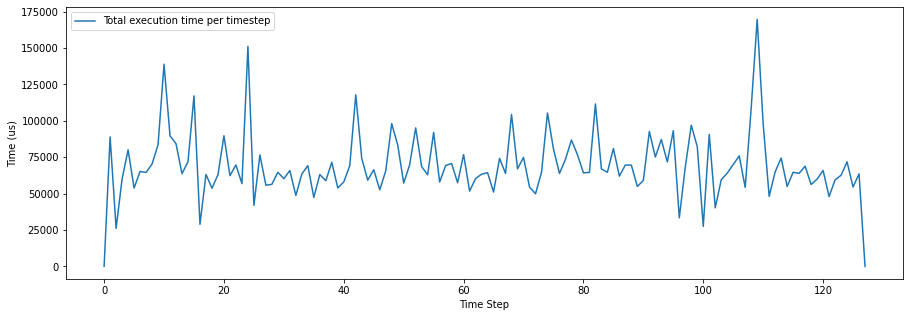

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(runtime_logger.execution_time_per_step, label='Total execution time per timestep')
plt.xlabel('Time Step')
plt.ylabel('Time (us)')
plt.legend()

## Power Results

The power profiler measures the power used by the Loihi system. It provies the individual measurements used by the 
* Loihi 2 neurocore circuits (`vdd_power`)
* Loihi 2 memory circuits (`vddm_power`)
* Loihi 2 input-output pheripherial circuits (`vddio_power`)

along with the total power (`total_power`). It also measures the static power of system when the system is idle.

In [11]:
# power measurements
vdd_p = power_logger.vdd_power  # neurocore power
vddm_p = power_logger.vddm_power  # memory power
vddio_p = power_logger.vddio_power  # IO power
total_power = power_logger.total_power

### Compensate for the idle chips on the board

The power measurement is done at a entire board level. PilotNet LIF runs on a single chip. So the static power consumed by the remaining Loihi 2 chips on the board need to be compensated.

In [12]:
num_chips = 1
if Loihi2.partition in ['kp', 'kp_stack', 'kp_build']:
    num_chips = 8

# per chip static power
static_total_power = power_logger.static_total_power / num_chips
static_vdd_p = power_logger.static_vdd_power / num_chips
static_vddm_p = power_logger.static_vddm_power / num_chips
static_vddio_p = power_logger.static_vddio_power / num_chips

# compensate for static power of multiple chip
total_power -= (num_chips - 1) * static_total_power
vdd_p -= (num_chips - 1) * static_vdd_p
vddm_p -= (num_chips - 1) * static_vddm_p
vddio_p -= (num_chips - 1) * static_vddio_p

In [13]:
total_power_mean = np.mean(total_power)
vdd_p_mean = np.mean(vdd_p)
vddm_p_mean = np.mean(vddm_p)
vddio_p_mean = np.mean(vddio_p)
print(f'Total Power   : {total_power_mean:.6f} W')
print(f'Dynamic Power : {total_power_mean - static_total_power:.6f} W')
print(f'Static Power  : {static_total_power:.6f} W')
print(f'VDD Power     : {vdd_p_mean:.6f} W')
print(f'VDD-M Power   : {vddm_p_mean:.6f} W')
print(f'VDD-IO Power  : {vddio_p_mean:.6f} W')

Total Power   : 0.363615 W
Dynamic Power : 0.009149 W
Static Power  : 0.354466 W
VDD Power     : 0.139124 W
VDD-M Power   : 0.218123 W
VDD-IO Power  : 0.006367 W


In [14]:
total_energy = total_power_mean / inference_rate
dynamic_energy = (total_power_mean - static_total_power) / inference_rate
print(f'Total Energy per inference   : {total_energy * 1e3:.6f} mJ')
print(f'Dynamic Energy per inference : {dynamic_energy * 1e3:.6f} mJ')

Total Energy per inference   : 25.566794 mJ
Dynamic Energy per inference : 0.643263 mJ


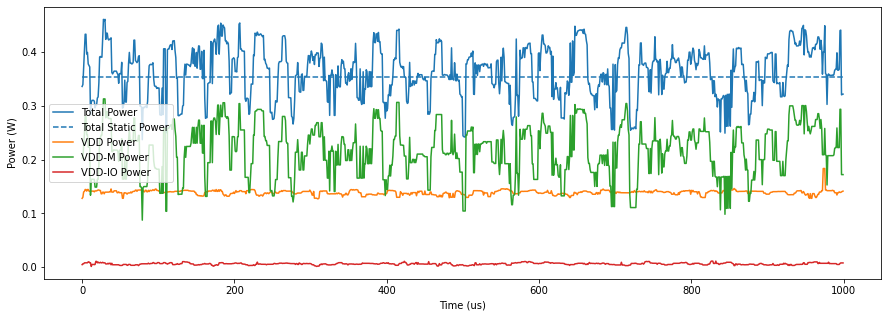

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(total_power, color=color, label='Total Power')
ax.plot(np.zeros_like(total_power)
        + static_total_power,
        linestyle='--', color=color, label='Total Static Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vdd_p, color=color, label='VDD Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vddm_p, color=color, label='VDD-M Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vddio_p, color=color, label='VDD-IO Power')
ax.set_ylabel('Power (W)')
ax.set_xlabel('Time (us)')
ax.legend()


## Activity Results

The activity profiler measures the Loihi 2 neurocore activity metrics such as synaptic operations (`syn_ops`), neuron_updates (`dendrite_updates`), input spikes (`spikes_in`), output spikes (`axon_out`). and more.

The activity metrics provide information about the bottlenecks in each cores and provide intution on where the netowrk and it's mapping can be improved.

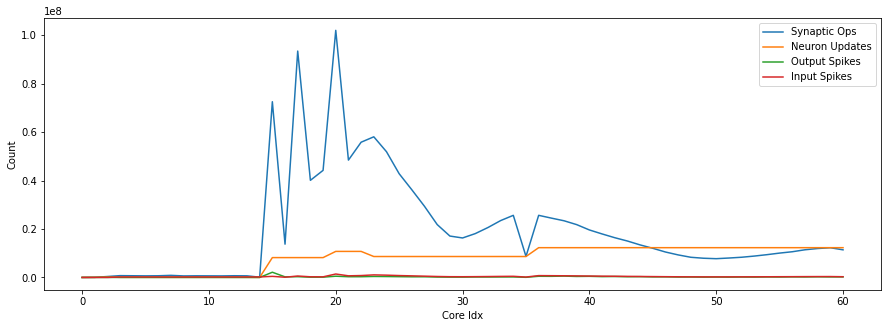

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(activity_logger.core_idx, activity_logger.syn_ops, label='Synaptic Ops')
plt.plot(activity_logger.core_idx, activity_logger.dendrite_updates, label='Neuron Updates')
plt.plot(activity_logger.core_idx, activity_logger.axon_out, label='Output Spikes')
plt.plot(activity_logger.core_idx, activity_logger.spikes_in, label='Input Spikes')
plt.xlabel('Core Idx')
plt.ylabel('Count')
plt.legend()

## Memory Results

The memory profiler mesasures the memory utilization of the individual Loihi cores. This gives an idea of how compactly the network is mapped to the Loihi 2 chip.

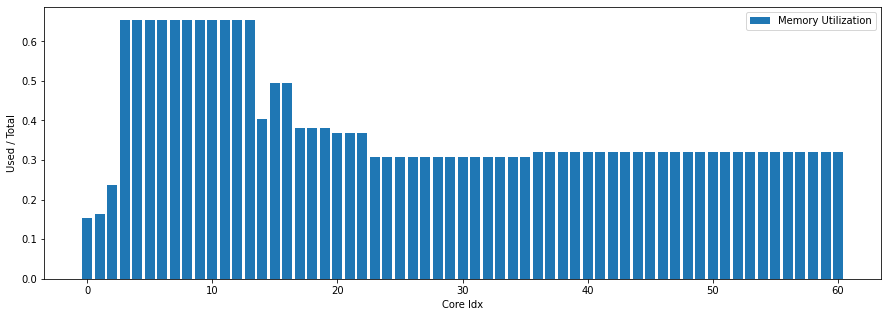

In [17]:
plt.figure(figsize=(15, 5))
plt.bar(memory_logger.core_idx, memory_logger.total_mpds, label='Memory Utilization')
plt.ylabel('Used / Total')
plt.xlabel('Core Idx')
plt.legend()